# Value Based Clustering

The goal is to identify which customers contribute the most financially.

### 2. Number of Clusters

      2.1 Evaluate the Number of Clusters with Hierarchical Clustering

      2.2 Evaluate the Number of Clusters with K-Means

### 5. Cluster Profile (Best Result)

      5.1 Number of Customers per Cluster

      5.2 City as a Factor

      5.3 Age as a Factor

      5.4 Paymenth Methods as  Factor

      5.5 Comparing Clusters with the Entire Dataset

      5.6 Final Cluster Profile

In [98]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [99]:
df_value_based = pd.read_csv("df_ready_for_clustering.csv")
df_value_based.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [100]:
df_value_based.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [101]:
value_features = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'TotalFlights'
]

df_value_based = df_value_based[value_features]


In [102]:
# Transform the features in df_value_based as needed (e.g., scaling, normalization)
scaler = StandardScaler()
df_value_based_scaled = scaler.fit_transform(df_value_based)  

df_value_based = pd.DataFrame(df_value_based_scaled, columns=value_features)

# Hierarchical Clustering 

In [ ]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_value_based.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df_value_based[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()


Ward linkage is the best method, since it gets the best r2 across all clusters.

In [ ]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_value_based, method="ward") 

In [ ]:
linkage_matrix.shape

# Column	Meaning
# 0	        Index of first cluster merged
# 1	        Index of second cluster merged
# 2	        Distance between them at merge (height in dendrogram)
# 3	        Number of original observations contained in the new cluster

(16573, 4)

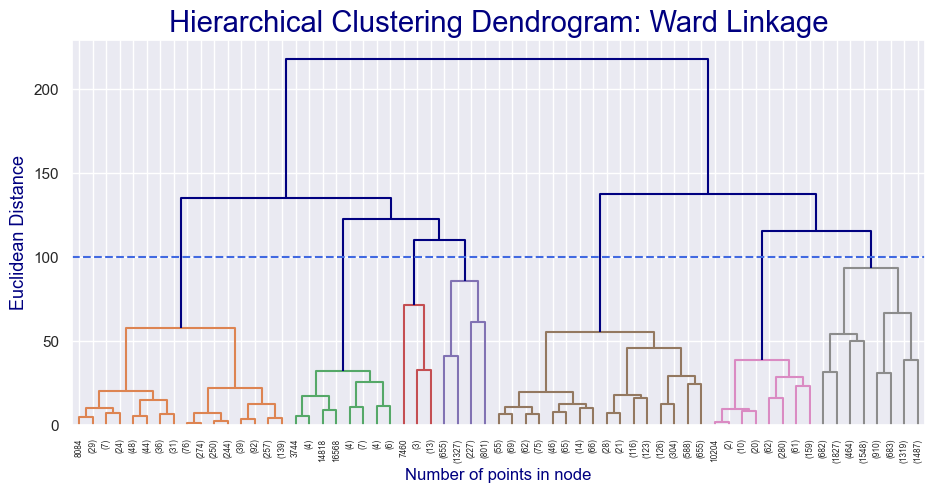

In [ ]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

let's try with nclusters = 2 and nclusters=3

In [ ]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 2
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels2 = hclust.fit_predict(df_value_based)

In [ ]:
df_concat = pd.concat([
    df_value_based, 
    pd.Series(hc_labels2, name='labels', index=df_value_based.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1
Customer Lifetime Value,0.045063,-0.115694
UnredeemedPoints,0.429577,-1.102883
PointsRedeemedRatio,0.035806,-0.091927
KMPerRedeemedPoint,0.268069,-0.688232
AvgDistancePerFlight,0.088056,-0.226071
FlightsWithCompanionsRatio,0.127549,-0.327465
TotalFlights,0.525288,-1.348608


In [ ]:
# Features used for clustering
X = df_value_based

# Compute metrics
silhouette = silhouette_score(X, hc_labels2)
calinski_harabasz = calinski_harabasz_score(X, hc_labels2)
davies_bouldin = davies_bouldin_score(X, hc_labels2)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.31639495855970434
Calinski-Harabasz Index: 4280.228492963495
Davies-Bouldin Index: 1.512422615308581


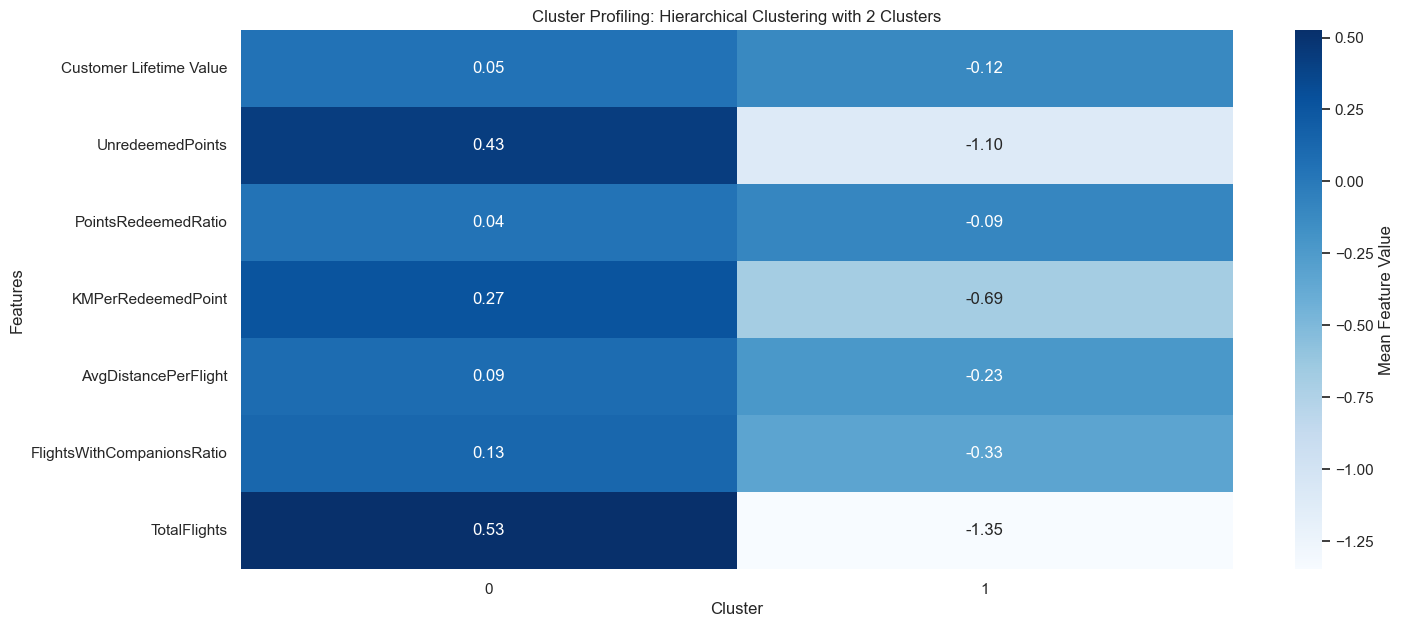

In [ ]:
X = df_value_based.copy()
X['labels'] = hc_labels2

cluster_means = X.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [ ]:
# 3 cluster solution

linkage = "ward" 
distance = "euclidean" 
n_clusters = 3
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels3 = hclust.fit_predict(df_value_based)

In [ ]:
df_concat = pd.concat([
    df_value_based, 
    pd.Series(hc_labels3, name='labels', index=df_value_based.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
Customer Lifetime Value,-0.115694,0.077029,-0.080984
UnredeemedPoints,-1.102883,0.262984,1.086492
PointsRedeemedRatio,-0.091927,0.126282,-0.320962
KMPerRedeemedPoint,-0.688232,-0.136466,1.863240
AvgDistancePerFlight,-0.226071,0.062990,0.186897
FlightsWithCompanionsRatio,-0.327465,0.136379,0.092732
TotalFlights,-1.348608,0.504606,0.606839


In [ ]:
# Features used for clustering
X = df_value_based

# Compute metrics
silhouette = silhouette_score(X, hc_labels3)
calinski_harabasz = calinski_harabasz_score(X, hc_labels3)
davies_bouldin = davies_bouldin_score(X, hc_labels3)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.209006708085226
Calinski-Harabasz Index: 3335.9891424937423
Davies-Bouldin Index: 1.524072173565996


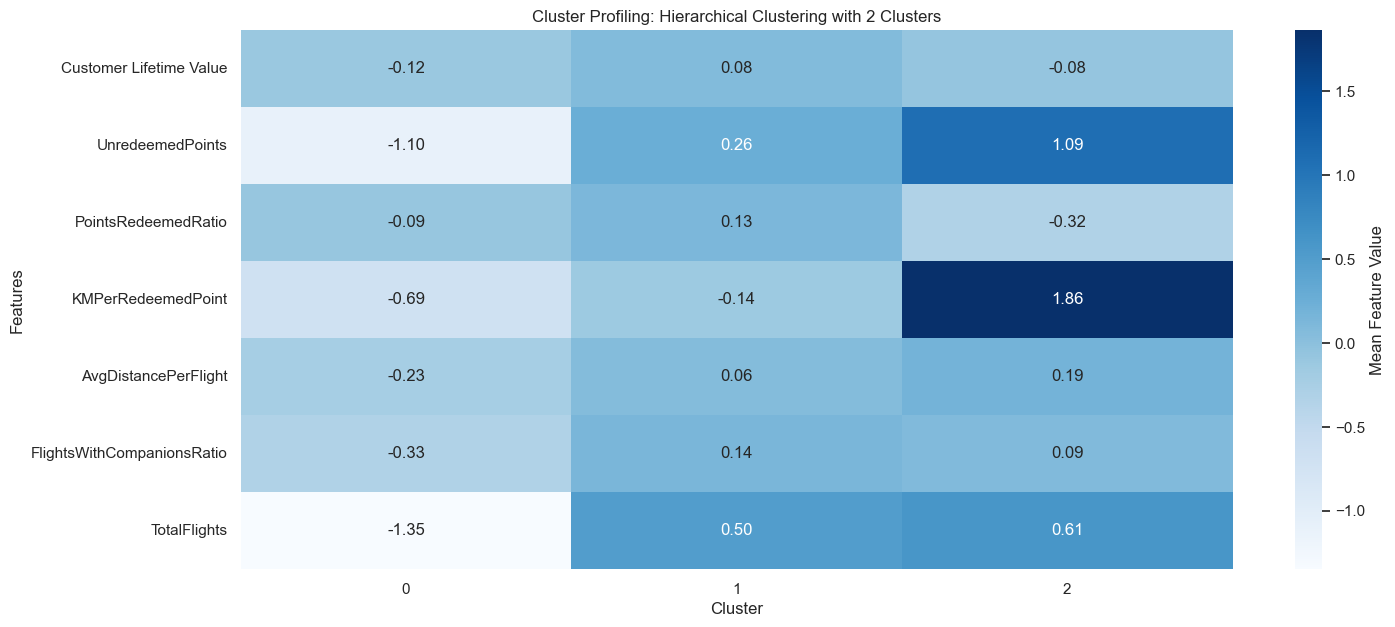

In [ ]:
Y = df_value_based.copy()
Y['labels'] = hc_labels3

cluster_means = Y.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [ ]:
## See crosstab of 3 vs 2

pd.crosstab(
    pd.Series(hc_labels3, name='hc3_labels', index=df_value_based.index),
    pd.Series(hc_labels2, name='hc2_labels', index=df_value_based.index),
    )

hc2_labels,0,1
hc3_labels,,
0,0,4646
1,9515,0
2,2413,0


# K-means Clustering 

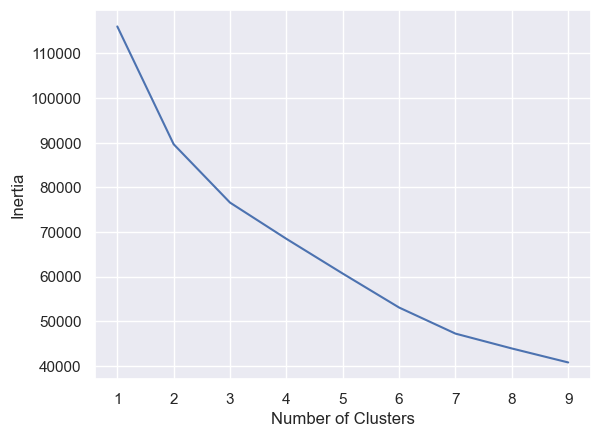

In [ ]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df_value_based)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

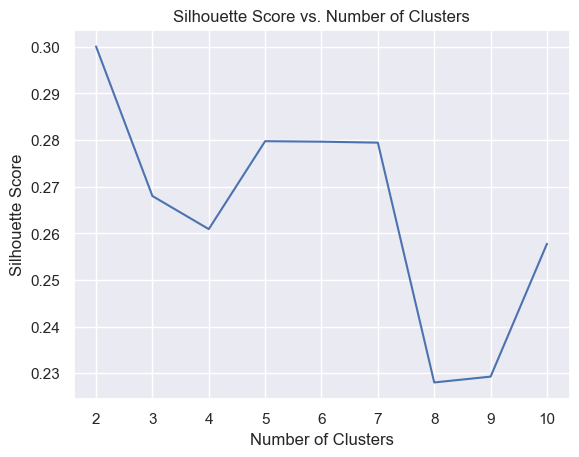

In [ ]:
s_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=94)  # Set random_state for reproducibility
    kmeans.fit(df_value_based)
    score = silhouette_score(df_value_based, kmeans.labels_)
    s_scores.append(score)

# Plot silhouette scores dynamically
plt.figure()  # Create a new figure for each iteration
plt.plot(n_clusters, s_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters')
plt.show()

Let's try nclusters=2,3,4

cluster,0,1
Customer Lifetime Value,0.005135,-0.002696
UnredeemedPoints,-1.081040,0.567576
PointsRedeemedRatio,0.068858,-0.036152
KMPerRedeemedPoint,-0.653465,0.343087
AvgDistancePerFlight,-0.293430,0.154059
FlightsWithCompanionsRatio,-0.249020,0.130742
TotalFlights,-1.132330,0.594504


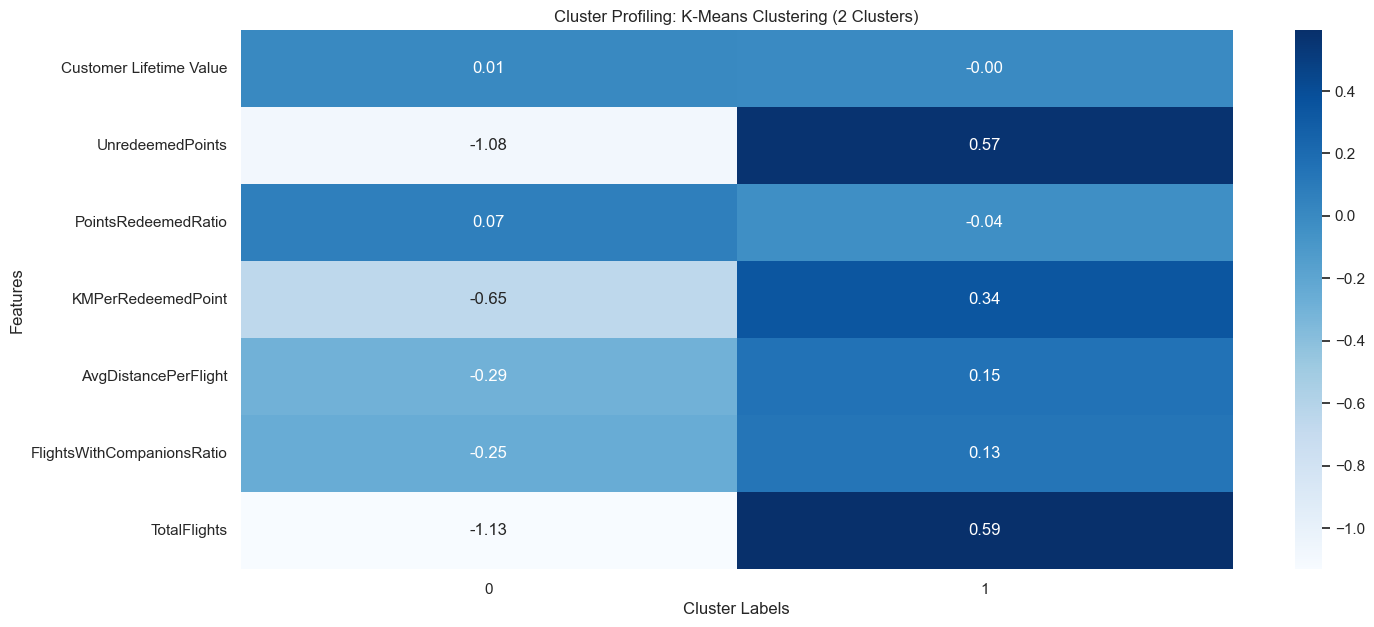

In [ ]:
km = KMeans(n_clusters=2, init="k-means++", random_state=94)
km_labels_2 = km.fit_predict(df_value_based)

df_value_based_with_clusters = df_value_based.copy()
df_value_based_with_clusters['cluster'] = km_labels_2

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2
Customer Lifetime Value,-0.036243,0.005591,0.056013
UnredeemedPoints,-0.695744,0.777340,-1.252827
PointsRedeemedRatio,0.512629,-0.150041,-0.545687
KMPerRedeemedPoint,-0.400249,0.482595,-0.843753
AvgDistancePerFlight,0.266913,0.099774,-0.902260
FlightsWithCompanionsRatio,0.665642,0.009026,-1.416885
TotalFlights,-0.378553,0.668986,-1.536564


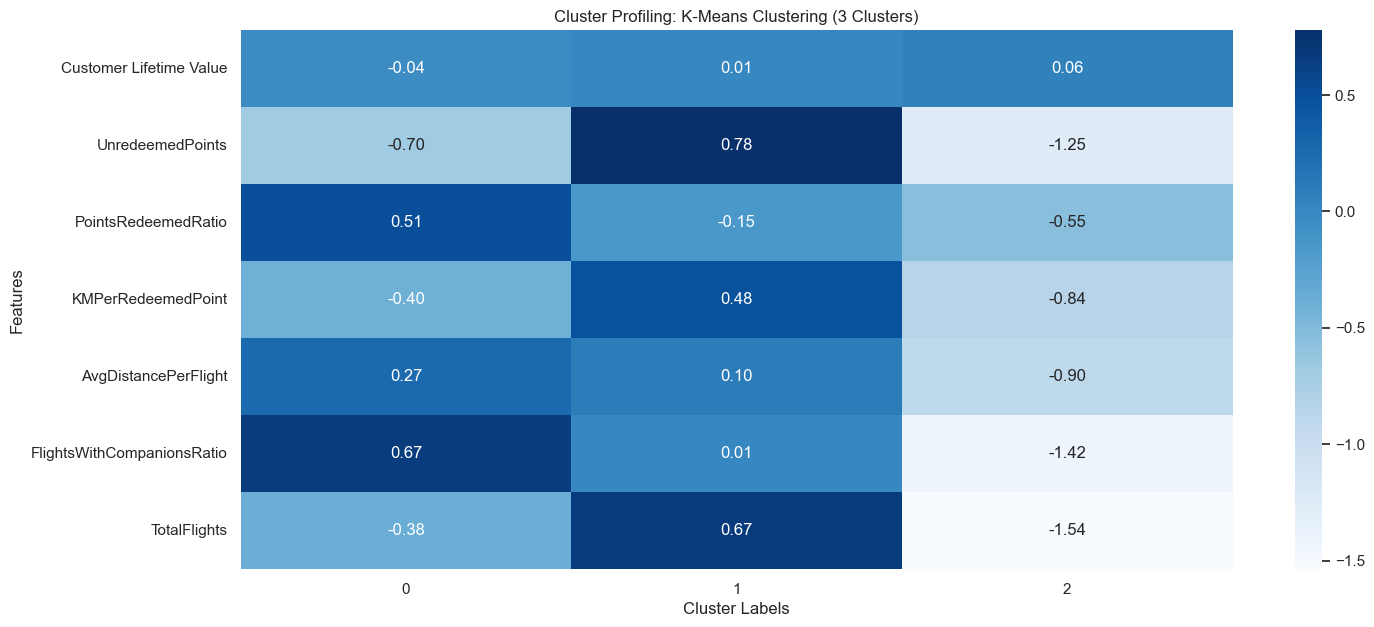

In [ ]:
km = KMeans(n_clusters=3, init="k-means++", random_state=94)
km_labels_3 = km.fit_predict(df_value_based)

df_value_based_with_clusters = df_value_based.copy()
df_value_based_with_clusters['cluster'] = km_labels_3

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (3 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2,3
Customer Lifetime Value,-0.043356,0.000401,0.045386,0.006597
UnredeemedPoints,-0.952372,0.391960,-1.247028,1.112643
PointsRedeemedRatio,0.547104,0.057817,-0.545107,-0.328009
KMPerRedeemedPoint,-0.488311,-0.121095,-0.841691,1.886202
AvgDistancePerFlight,0.410051,0.067639,-0.909717,0.181338
FlightsWithCompanionsRatio,0.845722,0.097918,-1.422714,0.054887
TotalFlights,-0.891163,0.594540,-1.532564,0.629280
Hierarchical_Cluster,0.300842,1.013056,0.018283,1.925851
K_Means_2_clusters,0.093264,0.990355,0.000000,1.000000


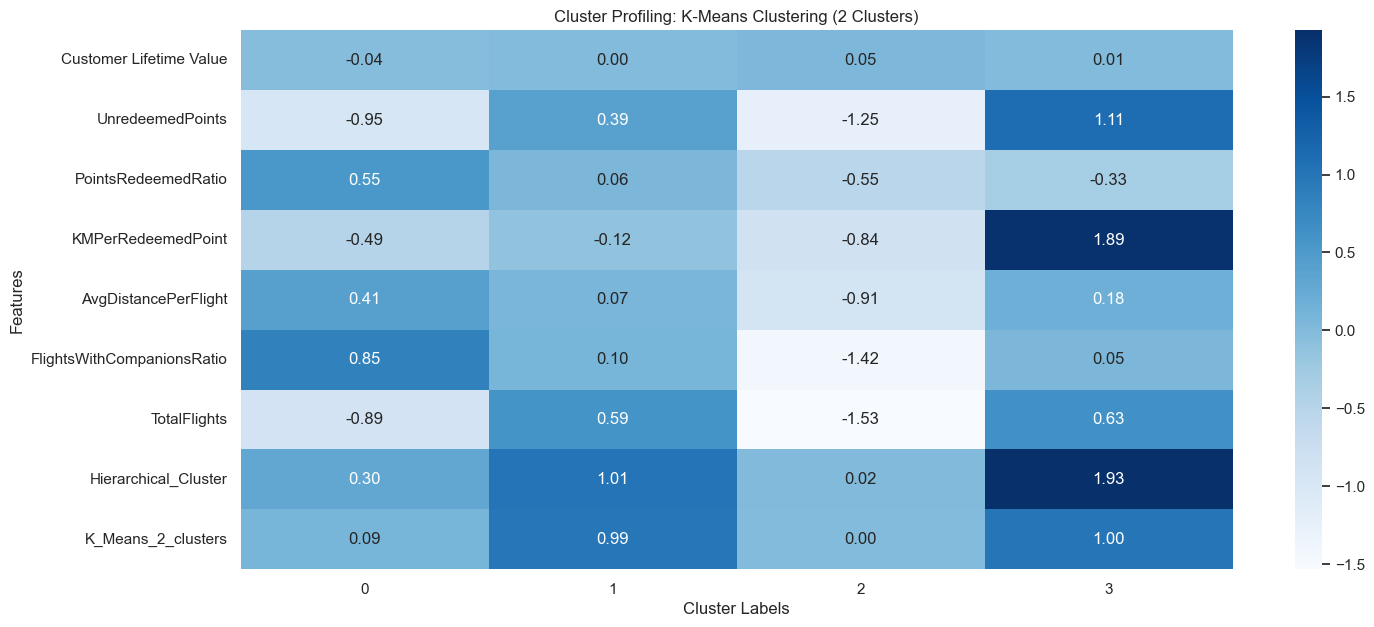

In [ ]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94)
km_labels_4 = km.fit_predict(df_value_based)

df_value_based_with_clusters = df_value_based.copy()
df_value_based_with_clusters['cluster'] = km_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


In [ ]:
# Features used for clustering
X = df_value_based
# Compute metrics for KMeans with 2 clusters
kmeans_2_silhouette = silhouette_score(X, km_labels_2)
kmeans_2_calinski_harabasz = calinski_harabasz_score(X, km_labels_2)
kmeans_2_davies_bouldin = davies_bouldin_score(X, km_labels_2)
# Compute metrics for KMeans with 3 clusters
kmeans_3_silhouette = silhouette_score(X, km_labels_3)
kmeans_3_calinski_harabasz = calinski_harabasz_score(X, km_labels_3)
kmeans_3_davies_bouldin = davies_bouldin_score(X, km_labels_3)

# Compute metrics for KMeans with 4 clusters
kmeans_4_silhouette = silhouette_score(X, km_labels_4)
kmeans_4_calinski_harabasz = calinski_harabasz_score(X, km_labels_4)
kmeans_4_davies_bouldin = davies_bouldin_score(X, km_labels_4)
# Create a comparison table
comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (2 Clusters)", "Hierarchical (3 Clusters)", "K-Means (2 Clusters)", "K-Means (3 Clusters)", "K-Means (4 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels2), silhouette_score(X, hc_labels3), kmeans_2_silhouette, kmeans_3_silhouette, kmeans_4_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels2), calinski_harabasz_score(X, hc_labels3), kmeans_2_calinski_harabasz, kmeans_3_calinski_harabasz, kmeans_4_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels2), davies_bouldin_score(X, hc_labels3), kmeans_2_davies_bouldin, kmeans_3_davies_bouldin, kmeans_4_davies_bouldin]
})
comparison_table.head()

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (2 Clusters),0.355578,5484.264872,1.336077
1,Hierarchical (3 Clusters),0.259064,4250.305970,1.359894
2,K-Means (2 Clusters),0.332002,5898.974933,1.351951
3,K-Means (3 Clusters),0.268241,4638.112752,1.438937
4,K-Means (4 Clusters),0.292903,4389.768292,1.365854


### Conclusion 
    
    Hierarchical (2 Clusters) is the best because it achieves the highest Silhouette Score (0.356) and Calinski-Harabasz Index (5484.26) while maintaining the lowest Davies-Bouldin Index (1.336), winning decisively on all three metrics.

    In addition, in terms of insights for customer segmentation analysis and marketing strategies.



Let's check for DBSCAN since it works well with outliers and works with dense regions.

KMeans has some limitations, such as assuming globular clusters and sensitivity to outliers, so that's why we are going to test DBSCAN, Mean Shift and GMM.

DBSCAN will be use to detect VIP Customers.

## Mean Shift

In [ ]:
bandwidth = estimate_bandwidth(df_value_based, quantile=0.3, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_value_based)

In [ ]:
n_clusters = len(np.unique(ms_labels))
print(pd.Series(ms_labels).value_counts().sort_index())

0     16431
1        45
2         8
3         5
4         6
5         4
6         6
7         4
8         2
9         3
10        2
11        1
12        1
13        3
14        1
15       39
16        1
17        1
18        4
19        2
20        1
21        1
22        1
23        1
24        1
Name: count, dtype: int64


In [ ]:
# Combine original features with cluster labels
df_with_labels = df_value_based.copy()
df_with_labels['labels'] = ms_labels

# Function to compute R²
def get_rsq(df, features, label_col):
    overall_mean = df[features].mean()
    ss_total = ((df[features] - overall_mean)**2).sum().sum()
    ss_within = df.groupby(label_col)[features].apply(lambda x: ((x - x.mean())**2).sum()).sum()
    return 1 - ss_within / ss_total

# Compute R² for Mean Shift clustering
r2_mshift = get_rsq(df_with_labels, value_features, 'labels')
print("R² for Mean Shift Clustering:", r2_mshift)


R² for Mean Shift Clustering: Customer Lifetime Value       0.858197
UnredeemedPoints              0.859382
PointsRedeemedRatio           0.948011
KMPerRedeemedPoint            0.857953
AvgDistancePerFlight          0.939873
FlightsWithCompanionsRatio    0.873096
TotalFlights                  0.860332
dtype: float64


With quantile = 0.3 we have 24 clusters wich are a lot. 

In [ ]:

# Compute metrics in PCA space
silhouette = silhouette_score(df_value_based, ms_labels)
calinski = calinski_harabasz_score(df_value_based, ms_labels)
davies_bouldin = davies_bouldin_score(df_value_based, ms_labels)

print("Mean Shift Clustering Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

Mean Shift Clustering Metrics:
Silhouette Score: 0.5340744578126572
Calinski-Harabasz Index: 168.9970244039696
Davies-Bouldin Index: 0.5928123362241611


## GMM

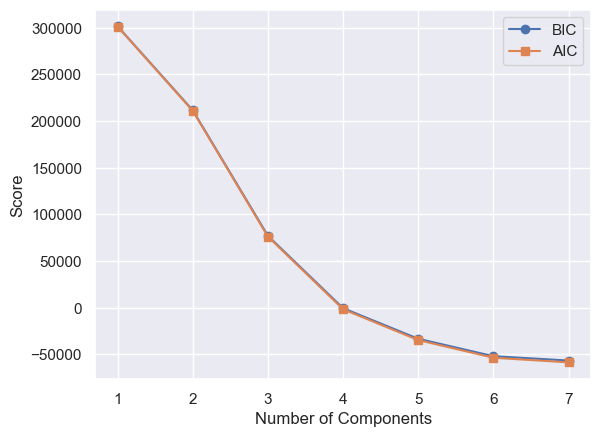

In [ ]:
from sklearn.mixture import GaussianMixture

# Decide number of components to test
n_components = np.arange(1, 8)

bic_values = []
aic_values = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', n_init=10, random_state=1)
    gmm.fit(df_value_based)  # or df_value_based
    bic_values.append(gmm.bic(df_value_based))
    aic_values.append(gmm.aic(df_value_based))

# Plot BIC and AIC
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.xticks(n_components)
plt.legend()
plt.show()


In [ ]:
best_gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=1)
gmm_labels = best_gmm.fit_predict(df_value_based)

In [ ]:
silhouette = silhouette_score(df_value_based, gmm_labels)
calinski = calinski_harabasz_score(df_value_based, gmm_labels)
davies_bouldin = davies_bouldin_score(df_value_based, gmm_labels)

print("GMM Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

GMM Metrics:
Silhouette Score: 0.24888233013342023
Calinski-Harabasz Index: 2479.8109904175544
Davies-Bouldin Index: 1.7415388022626852


## DBSCAN

Since we have a lot of outliers in our dataset, we will use DBSCAN since this algorithm handles well with outliers.

In [ ]:
# Run DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # adjust eps/min_samples as needed
db_labels = dbscan.fit_predict(df_value_based)

In [ ]:
mask = db_labels != -1
X_filtered = df_value_based[mask]
labels_filtered = db_labels[mask]

In [ ]:
silhouette = silhouette_score(X_filtered, labels_filtered)
calinski = calinski_harabasz_score(X_filtered, labels_filtered)
davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)

print("DBSCAN Metrics (excluding noise):")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)


DBSCAN Metrics (excluding noise):
Silhouette Score: 0.8296302502387849
Calinski-Harabasz Index: 281.9395387263044
Davies-Bouldin Index: 0.16934209813220333


| METHOD | Silhouette | Calinski-Harabasz| Davies-Bouldin Index | 
| --- | --- | --- | --- |
| Hierarchical 2 clusters | 0.35 | 5484 | 1.33 | 
| GMM | 0.24 | 2479 | 1.74|
| DSCAN | 0.82| 281 | 0.16 | 
| Mean Shift | 0.53 | 168 | 0.59 | 


With this table, we can see that DBSCAN has the best Silhouete score, which means that is the best method to separate clusters, however we will choose Hierarchical 2 Clusters since DBSCAN does not take into account outliers, the reason why we have a high score.

After defining that the method is Hierarchical Clustering (3), we will use DBSCAN to add a label where we will have VIP customers, since this are the outliers.

In [ ]:
df_value_based.head()

,Customer Lifetime Value,UnredeemedPoints,PointsRedeemedRatio,KMPerRedeemedPoint,AvgDistancePerFlight,FlightsWithCompanionsRatio,TotalFlights,Hierarchical_Cluster,K_Means_2_clusters
0,-0.009812,0.874199,0.205716,-0.058210,0.266210,-0.212101,1.097950,1,1
1,-0.743444,-0.369430,0.545702,-0.301712,-0.459889,-0.030281,1.351616,1,1
2,-0.750686,1.294395,-0.358413,1.914416,0.035457,0.097539,0.920384,2,1
3,-0.556396,0.234454,0.136239,0.019536,1.027348,-0.528323,-0.385996,1,1
4,-0.198948,0.846315,-0.070293,0.373282,0.278957,0.353953,0.539885,1,1


## 5. Cluster Profiling

In [ ]:

km = KMeans(n_clusters=2, random_state=42)
df_value_based['K_Means_2_clusters'] = km.fit_predict(df_value_based)

cluster_means_scaled = df_value_based.groupby('K_Means_2_clusters').mean()
print(cluster_means_scaled)

if 'scaler' in globals():
    centroids = km.cluster_centers_
    real_centroids = scaler.inverse_transform(centroids)
    print(pd.DataFrame(real_centroids, columns=df_value_based.columns[:-1]))

fig, ax = plt.subplots(figsize=(16,7))
df_value_based['K_Means_2_clusters'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Number of data points per cluster')
plt.show()

                    Customer Lifetime Value  UnredeemedPoints  \
K_Means_2_clusters                                              
0                                  0.000208         -1.093007   
1                                 -0.000100          0.527922   

                    PointsRedeemedRatio  KMPerRedeemedPoint  \
K_Means_2_clusters                                            
0                              0.021732           -0.665132   
1                             -0.010496            0.321258   

                    AvgDistancePerFlight  FlightsWithCompanionsRatio  \
K_Means_2_clusters                                                     
0                              -0.279068                   -0.260765   
1                               0.134790                    0.125949   

                    TotalFlights  Hierarchical_Cluster  
K_Means_2_clusters                                      
0                      -1.219520              0.154316  
1                       0.

ValueError: operands could not be broadcast together with shapes (2,8) (7,) (2,8) 